# Study 1 part 1: Sketching sounds - an exploratory study on sound-shape associations

In [1]:
#Libraries that are used in this notebook
#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
from matplotlib.colors import ListedColormap, LogNorm

#Datastructures
import pandas as pd
import numpy as np
import json
import math

#Sound feature extraction
import librosa
import librosa.display
import timbral_models
import soundfile as sf

#Statistics and data processing
import scipy.stats as stats
import scipy.signal as signal
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize,minmax_scale
from sklearn.mixture import GaussianMixture

#"Homemade" scripts
from sketchinfo import eucledian_dist
from shortstraw import *
from sketchinfo import *
from prepare_drawing_data import *

#Misc
from collections import Counter
from wordcloud import WordCloud, get_single_color_func

/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Datasets 

JSON file contains all data collected from the study

CSV file for particpant information has been extracted from the firebase JSON file with a different python script.

CSV file for categorising the sketches has been created manually based on the actual sketches and the participant interviews: 

In [2]:
#Create array to name sounds 
sound_index = ['Crackles','Telephonic','Strings','String Grains','Subbass','Noise','Piano','Impact','Processed Guitar','Electric Guitar']

#Define important constants  
nos = 10 #Number of Sounds
nop = 28 #Number of Participants

#Import JSON file
with open('../datasets/data.json','r') as f:
    raw_data = json.load(f)
    
#Create dataframe with personal information from CSV
personal_df = pd.read_csv (r'../datasets/personal_data.csv') 

#Create dataframe with sketch categories from CSV
#0: Notational 1: Representational 2:Abstract
cat_df = pd.read_csv(r'../datasets/sketch_categories.csv',index_col=0)

#Create dataframe with data extracted from interviews
interview_df = pd.read_csv(r'../datasets/interviews_quantitative.csv')

#Create dataframe with the raw sketch data from the p5.js canvas for each participant and sound
sketch_data,order_data = prepare_drawing_data(raw_data,nos)

# I. General Information 

## 1. Participant Dataframe 

In [3]:
personal_df

Dataframe omitted for publication

## 2. Display participant summary as barplots

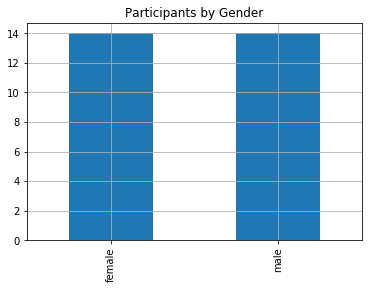

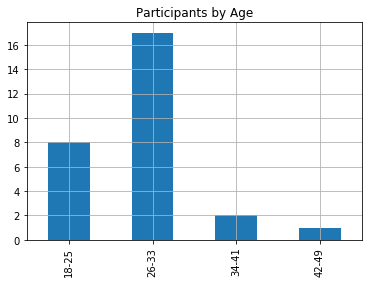

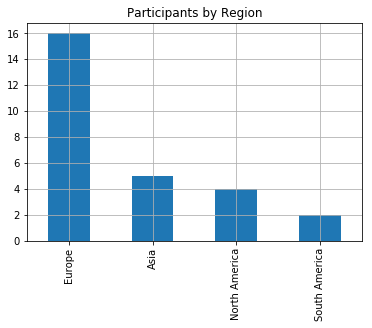

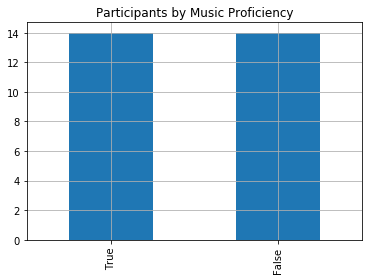

In [4]:
#Gender
series = personal_df['Gender'].value_counts()
gender_df = series.to_frame()
gender_df.plot.bar(title='Participants by Gender',legend=False,grid=True)

#Age
series = personal_df['Age'].value_counts(sort=False)
age_df = series.to_frame()
age_df = age_df.sort_index()
age_df.plot.bar(title='Participants by Age',legend=False, grid=True)

#Continent
series = personal_df['Continent'].value_counts()
continent_df = series.to_frame()
continent_df.plot.bar(title='Participants by Region',legend=False, grid=True)

#Musician 
series = personal_df['Music Pro'].value_counts()
musician_df = series.to_frame()
musician_df.plot.bar(title='Participants by Music Proficiency',legend=False, grid=True)

# II. Interview analysis

## 1. Thematic analysis

Thematic analysis proposed by Braun and Clarke has been applied to the transcribed interviews.  

In [9]:
#Categories
music_jargon = ['DAW','MIR','amplitude','attack','waveform','vibrato','transient','timbre','synthesis','spectrum','spectrogram','resonant','reverb','panning','sustained','oscillating','onset','modulation','harmonics','granular','frequency','envelope','distortion','volume','tonal','tuning','source','binaural','electronic','groove','rhythmic','drone','dynamic','decay','pitch','processing','presence','accentuated','ambient','chord','monotone']
sound_source = ['wave','water','strings','sand','rain','piano','explosion','firework','guitar','gun','impact','instrument','laser','lightsabre','boat']
sound_adjective =['buzzy','grainy','scratchy','pure','fragmented','crackly','clear','clean','click','noise','loud']
visual = ['texture','symmetry','colour','circle','blob','boxy','bright','curve','edge','flat','gradient','jagged','line','pyramid','round','scribbly','shape','sharp','spikey','square','triangle']
temporal = ['time','vibrating','static','pulse','movement','impulse','abrupt','continuous']
spatial = ['spatial','size','short','high','front','deep','dense','sparse','low','long','space','hollow','big']
emotional = ['strong','shaking','scary','harsh','gentle','feeling','aggressive','comfortable','peaceful','ominious','soft','smooth','mellow','comical']
abstract_words = ['structure','stochastic','rigid','abstract','energy','intensity','spark']

sound_description = []
for i in range(interview_df.shape[0]):
    sound_description.extend(interview_df['Sound Description'].str.split()[i])

sound_description_categories = np.empty(8)
for pt in range(interview_df.shape[0]):
    words = interview_df['Sound Description'].str.split()[pt]
    count = [0,0,0,0,0,0,0,0]    
    for word in words:       
        if word in music_jargon:
            sound_description_categories[0] += 1
        elif word in sound_source:
            sound_description_categories[1] += 1
        elif word in sound_adjective:
            sound_description_categories[2] += 1
        elif word in visual:
            sound_description_categories[3] += 1
        elif word in temporal:
            sound_description_categories[4] += 1
        elif word in spatial:
            sound_description_categories[5] += 1
        elif word in emotional:
            sound_description_categories[6] += 1
        elif word in abstract_words:
            sound_description_categories[7] += 1

            
Counter(sound_description).most_common(10)

[('piano', 16),
 ('strings', 11),
 ('guitar', 10),
 ('noise', 8),
 ('crackly', 7),
 ('movement', 7),
 ('flat', 6),
 ('line', 6),
 ('amplitude', 6),
 ('spatial', 6)]

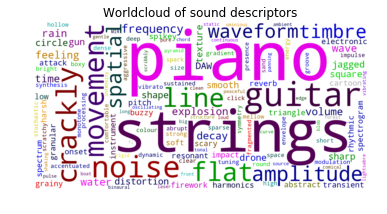

In [22]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

# Since the text is small collocations are turned off and text is lower-cased
text = ''
for word in sound_description:
    text += word + ' '
wc = WordCloud(collocations=False,width=1600,height=800,background_color='white').generate(text)

color_to_words = {}
color_to_words['blue'] = music_jargon
color_to_words['magenta'] = sound_source
color_to_words['red'] = sound_adjective
color_to_words['green'] = visual
color_to_words['indigo'] = temporal
color_to_words['cyan'] = spatial
color_to_words['orange'] = emotional
color_to_words['yellow'] = abstract_words

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

#Save File
#wc.to_file('wordcloud.png')
# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Worldcloud of sound descriptors')
plt.show()

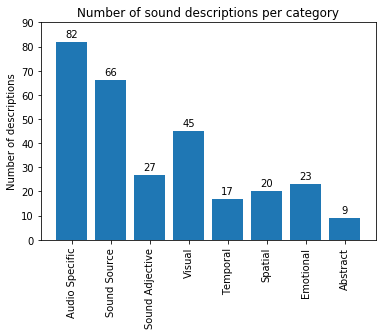

In [23]:
x = np.arange(sound_description_categories.shape[0])
width = 0.8
plt.bar(x,sound_description_categories, width)
plt.title('Number of sound descriptions per category')
plt.ylabel('Number of descriptions')
plt.ylim(0,90)
plt.xticks(x,['Audio Specific','Sound Source','Sound Adjective','Visual','Temporal','Spatial','Emotional','Abstract'])
#Display names on x-axis

for i,x_pos in enumerate(x):
    plt.text(x_pos,sound_description_categories[i]+2,s=str(int(sound_description_categories[i])),horizontalalignment='center')

_, labels = plt.xticks()
plt.setp(labels, rotation=90)   
    
plt.show()

## 2. Interface and Task rating 

From the interviews we extracted a value from 0-4 that says how participants rated the interaction with the interface and how difficult they thought the task was. 

In [7]:
#Analyse data on difficulty of task and the drawing interface
difficulty = interview_df['Difficulty']
interface = interview_df['Drawing Interface']

interface_description = []
for i in range(interview_df.shape[0]):
    words = interview_df['Preferred Interface'].str.split()[i]
    if isinstance(words,str):
        interface_description.append(words)
    elif isinstance(words,list):
        interface_description.extend(words)

print(Counter(interface_description).most_common(10))
print('Mean difficulty ' + '{:1.2f}'.format(np.mean(difficulty)))
print('Mean interface satisfaction ' + '{:1.2f}'.format(np.mean(interface)))
    

[('pen', 12), ('colour', 3), ('mouse', 2), ('brushstrokes', 2), ('tablet', 2), ('charcoal', 1), ('touchpad', 1), ('3D', 1), ('erase', 1), ('paint', 1)]
Mean difficulty 2.32
Mean interface satisfaction 1.32


# III. Audio Analysis

## 1. Feature extraction

Extracting features with the librosa library and the timbreModels library.


In [8]:
#Find local maxima and minima
def local_extrema(array):
    maxima = []
    minima = []
    for i in range(1,len(array)-1):
        if array[i-1]<array[i] and array[i]>array[i+1]:
            maxima.append(i)
        if array[i-1]>array[i] and array[i]<array[i+1]:
            minima.append(i)
    return maxima,minima

#Calculate gradient between minima and maxima 
def extrema_gradient(maxima,minima,y):
    l = len(maxima)
    y = minmax_scale(y)
    min_index = 0
    gradients = []
    for max_index in range(l-1):
        i = maxima[max_index]
        i_next = maxima[max_index+1]
        j = minima[min_index]
        while j<i:
            min_index += 1
            j = minima[min_index]
        if i<j and j<i_next:
            m1 = (y[j]-y[i])/(j-i)
            m2 = (y[i_next]-y[j])/(i_next-j)
            gradients.append(m1)
            gradients.append(m2)
            min_index += 1
    
    return gradients

In [9]:
sr = 44100

spec_info = np.empty([10,13])
mfccs = []
flatness = []
centroid = []
rms = []
timbre = []
for i in range(nos):
    # Load the example clip
    filename = '../../data/Audio/sound' + str(i+1) + '.wav'
    y, sr = librosa.load(filename,sr=sr)
    
    #Get rid of silence in audio
    y, index = librosa.effects.trim(y)
    
    #Save trimmed audiofiles
    #sf.write('sound' + str(i+1) + '_trimmed.wav',y,44100,'PCM_24')
    
    #Calculate flatness or Wiener Entropy
    f = librosa.feature.spectral_flatness(y=y)
    flatness.append(f)
    spec_info[i,0] = np.mean(f)
    
    #Calculate spectral centroid frequency
    c = librosa.feature.spectral_centroid(y=y,sr=sr)
    centroid.append(c)
    spec_info[i,1] = np.mean(c)
    
    #Calculate Root Mean Square
    r = librosa.feature.rms(y=y)
    rms.append(r)
    spec_info[i,2] = np.mean(r)
    
    #Calculate the intensity of the root mean square
    b, a = signal.butter(5,0.1)
    smooth = signal.filtfilt(b,a,r[0], padlen=10)
    smooth = smooth[:len(smooth)-50] #Cut off last 50 frames to avoid the fade out
    max_x,min_x = local_extrema(smooth)
    max_y,min_y = [smooth[k] for k in max_x],[smooth[k] for k in min_x]
    
    mg = extrema_gradient(max_x,min_x,smooth)
    abs_mg = [abs(k) for k in mg]
    
    spec_info[i,3] = np.mean(abs_mg)
    
    #Calculate zero crossings
    zero = librosa.feature.zero_crossing_rate(y)
    spec_info[i,4] = np.mean(zero)
    
    #Calculate Timbre Features Andy Pierce Audio Commons
    timbre.append(timbral_models.timbral_extractor(filename))
    for j,feature_name in enumerate(timbre[-1]):
        spec_info[i,j+5] = timbre[-1][feature_name]

    
    #Calculate mfccs
    mfcc = librosa.feature.mfcc(y,sr=sr,n_mfcc=16)
    #mfcc = mfcc[...,:400] #Give all arrays the same shape
    mfccs.append(mfcc)


Calculating hardness...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating depth...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating brightness...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating roughness...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating warmth...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating sharpness...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating boominess...


/anaconda/lib/python3.6/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


Calculating reverb...
Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...
Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...
Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...
Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...
Calculating hardness...
Calculating depth...
Calculating brightness...
Calculating roughness...
Calculating warmth...
Calculating sharpness...
Calculating boominess...
Calculating reverb...
Calculating hardness...
Calc

In [10]:
from scipy import signal

all_envelope_data = []

for snd in range(nos):
    b, a = signal.butter(5,0.1)
    y = signal.filtfilt(b,a,rms[snd][0], padlen=10)
    y = y[:len(y)-50] #Cut off last 50 frames to avoid the fade out
    max_x,min_x = local_extrema(y)
    max_y,min_y = [y[i] for i in max_x],[y[i] for i in min_x]
    
    mg = extrema_gradient(max_x,min_x,y)
    abs_mg = [abs(i) for i in mg]
    
    all_envelope_data.append([len(max_x)+len(min_x),np.mean(abs_mg)]) 

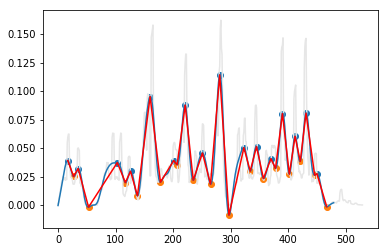

In [11]:
from scipy import signal

snd = 0

b, a = signal.butter(5,0.1)
y = signal.filtfilt(b,a,rms[snd][0], padlen=10)
y = y[:len(y)-50] #Cut off last 50 frames to avoid the fade out
max_x,min_x = local_extrema(y)
max_y,min_y = [y[i] for i in max_x],[y[i] for i in min_x]

all_extrema_x = []
all_extrema_y = []
for i in range(len(max_x)):
    all_extrema_x.append(max_x[i])
    all_extrema_x.append(min_x[i])
    all_extrema_y.append(max_y[i])
    all_extrema_y.append(min_y[i])
    
plt.plot(rms[snd][0],color=(0.9,0.9,0.9))
plt.scatter(max_x,max_y)
plt.scatter(min_x,min_y)
plt.plot(y)
plt.plot(all_extrema_x,all_extrema_y,color='red')

In [12]:
#Display audio analysis dataframe
audio_df = pd.DataFrame(data = spec_info,index=sound_index,columns=['Flatness Mean','Centroid Mean','RMS Mean','RMS Change','Zero Crossing Mean','Hardness','Depth','Brightness','Roughness','Warmth','Sharpness','Boominess','Reverb'])
audio_df.drop('Reverb',axis=1)

,Flatness Mean,Centroid Mean,RMS Mean,RMS Change,Zero Crossing Mean,Hardness,Depth,Brightness,Roughness,Warmth,Sharpness,Boominess
Crackles,4.119022e-02,1727.578938,0.032432,0.020979,0.035339,54.758941,27.730938,60.344542,51.524106,41.483392,48.004749,16.778425
Telephonic,1.055878e-03,543.056122,0.156891,0.005190,0.012559,33.713322,66.847890,43.241975,50.182383,54.311901,28.092424,40.913438
Strings,3.920414e-05,1042.084967,0.151401,0.009664,0.020062,41.715273,56.873260,52.315885,51.527741,53.791557,34.759910,32.639069
String Grains,1.908907e-03,1177.309162,0.106869,0.021538,0.031331,51.941866,40.463255,56.032304,56.092211,48.662343,37.060513,25.267890
Subbass,1.597988e-08,206.394654,0.416351,0.001443,0.002496,34.296886,77.215183,35.568045,46.801676,64.548888,34.224115,46.973140
Noise,2.948475e-01,7915.456887,0.085704,0.034160,0.144320,80.856819,43.583050,81.309430,80.955322,28.761831,68.094841,21.799193
Piano,4.507914e-07,541.615267,0.051404,0.001438,0.012571,42.003680,64.713217,49.340369,40.082194,53.711359,30.585245,42.253216
Impact,2.805764e-04,1046.889349,0.096619,0.007555,0.011181,64.625947,76.677677,60.403448,48.820538,51.035470,49.168742,38.850514
Processed Guitar,1.755188e-03,229.438620,0.343751,0.002997,0.002390,29.546450,80.028038,39.388758,40.095762,62.737488,36.651694,45.656951
Electric Guitar,4.586856e-06,1294.658451,0.304892,0.004777,0.022469,46.603233,55.612225,56.273553,56.362103,49.909804,41.783937,33.761132


## 2. Dissimilarity Matrix

Train GMMs on the MFCCs values and calculate symmetrised KL-Divergence for dissimiliarty matrix

In [13]:
#Use mfccs
sound_models = []
for snd in range(nos):
    feature = mfccs[snd].T
    #feature_norm = minmax_scale(feature).T
    g = GaussianMixture(n_components=10,covariance_type='full',n_init=10,max_iter=500)
    g.fit(feature)
    sound_models.append(g)

In [14]:
from sklearn.mixture import GaussianMixture

def gmm_js(gmm_p, gmm_q, n_samples=1000):
    X,y = gmm_p.sample(n_samples)
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y,y = gmm_q.sample(n_samples)
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return 0.5 * (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2)))

def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X,y = gmm_p.sample(n_samples)
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    
    Y,y = gmm_q.sample(n_samples)
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    
    
    return 0.5*(abs(log_p_X.mean() - log_q_X.mean()) + abs(log_p_Y.mean() - log_q_Y.mean()))

In [15]:
dm = np.zeros((nos,nos))

for i in range(nos):
    #Don't calculate the symmetric values twice, save computing time
    for j in range(i,nos):
        d = gmm_kl(sound_models[i],sound_models[j])
        dm[i,j]= d
        dm[j,i]= d        

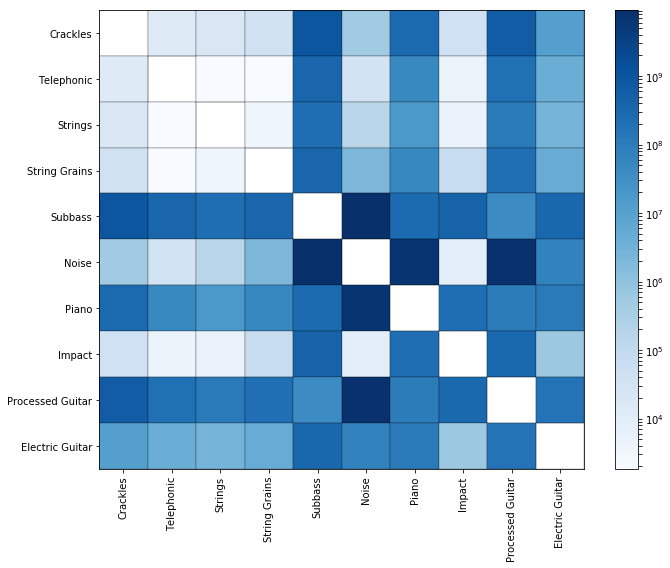

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
dis_matrix = ax.pcolor(dm, cmap=plt.cm.__dict__['Blues'], edgecolors='k', alpha=1, snap=True, norm=LogNorm())

#legend
cbar = plt.colorbar(dis_matrix)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(dm.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(dm.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

#labels
column_labels = sound_index
row_labels = sound_index
ax.set_xticklabels(column_labels, minor=False, rotation=90)
ax.set_yticklabels(row_labels, minor=False)

fig.tight_layout()
plt.show()

Create dissimilarity matrix based on eucledian distance between feature vectors

In [17]:
#Eucledian distance between standardised feature vectors
std_audio_ft = np.empty([10,12])

for i in range(spec_info.shape[1]-1):
    temp_column = minmax_scale(spec_info[:,i],(0,1))
    for j,val in enumerate(temp_column):
        std_audio_ft[j,i] = val

eucl_dst = np.zeros((nos,nos))
for i in range(nos):
    #Don't calculate the symmetric values twice, save computing time
    a = std_audio_ft[i]
    for j in range(i,nos):
        b = std_audio_ft[j]
        d = np.linalg.norm(b-a)
        eucl_dst[i,j]= d
        eucl_dst[j,i]= d


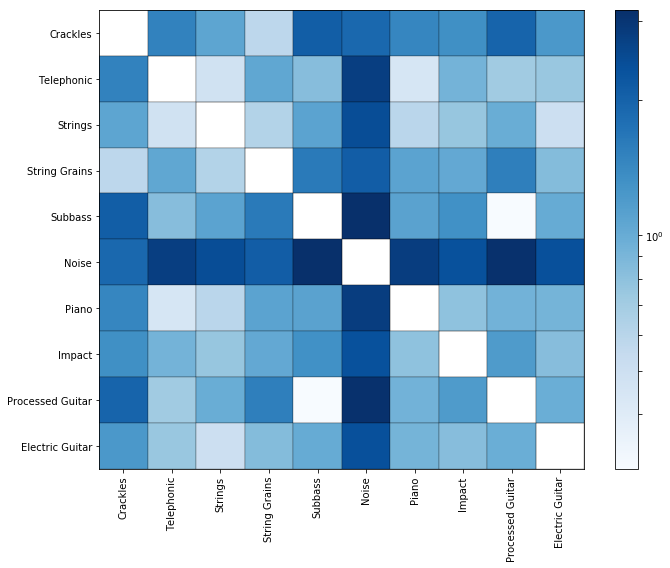

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
dis_matrix = ax.pcolor(eucl_dst, cmap=plt.cm.__dict__['Blues'], edgecolors='k', alpha=1, snap=True, norm=LogNorm())

#legend
cbar = plt.colorbar(dis_matrix)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(dm.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(dm.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

#labels
column_labels = sound_index
row_labels = sound_index
ax.set_xticklabels(column_labels, minor=False, rotation=90)
ax.set_yticklabels(row_labels, minor=False)

fig.tight_layout()
plt.show()

In [19]:
snd = 3
ranks = np.argsort(eucl_dst[snd])

print('For '+sound_index[snd]+':\n1.'+sound_index[ranks[1]]+'\n4.'+sound_index[ranks[4]]+'\n6.'+sound_index[ranks[6]]+'\n9.'+sound_index[ranks[9]])

For String Grains:
1.Crackles
4.Impact
6.Piano
9.Noise


# IV. Sketch Analysis

## 1. Different sketch categories

We analysed the different sketches and found 3 general categories:

    1. Abstract = Sketches that represent the sounds through shapes and lines rather than images 
    2. Notational = Sketches that use existing representation schemes like wavefors, spectrograms or envelope shape
    3. Representational = Sketches that show associations with a sound, for example an image of the sound source 
    
Many sketches showed elements from more than one category, therefore we gave each sketch a score for each category in the intervals 0,$\frac{1}{3}$,$\frac{1}{2}$,$\frac{2}{3}$,1 

In [20]:
#Prepare categories
notational = []
representational = []
abstract = []
for i in range(1,2*nop+1):
    n_temp = []
    r_temp = []
    a_temp = []
    for j in range(1,nos+1):
        pt = str(math.ceil(i/2))
        if i%2 == 0:
            pt = pt + 'B'
        value = cat_df.loc['Sound ' + str(j),'Part ' + pt]
        value = value.split()
        #Divide values by 3 so the range is 0 to 1
        n_temp.append(float(value[0])/3)
        r_temp.append(float(value[1])/3)
        a_temp.append(float(value[2])/3)

    notational.append(n_temp)
    representational.append(r_temp)
    abstract.append(a_temp)   

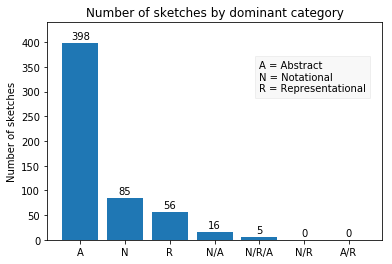

In [21]:
#Count how often each category is the dominant one (value above 0.5 )
n_count = 0 #Mainly notational
r_count = 0 #Mainly representational
a_count = 0 #Mainly abstract
na_count = 0 #Equally notational and abstract
nr_count = 0 #Equally notational and representational
ar_count = 0 #Equally abstract and representational 
nra_count = 0 #Equally all categories 


for i in range(0,2*nop):
    for j in range(0,nos):
        n = notational[i][j]
        r = representational[i][j]
        a = abstract[i][j]
        
        if n >= 0.5 and r < 0.5 and a < 0.5:
            n_count += 1
        elif r >= 0.5 and n < 0.5 and a < 0.5:
            r_count += 1
        elif a >= 0.5 and n < 0.5 and r < 0.5:
            a_count += 1
        elif n == 0.5 and r == 0.5:
            nr_count += 1
        elif n == 0.5 and a == 0.5:
            na_count += 1
        elif a == 0.5 and r == 0.5:
            ar_count += 1
        else:
            nra_count += 1

all_counts = [a_count,n_count,r_count,na_count,nra_count,nr_count,ar_count]

x = np.arange(len(all_counts))
width = 0.8
plt.bar(x,all_counts, width)
plt.title('Number of sketches by dominant category')
plt.text(4,300,'A = Abstract\nN = Notational\nR = Representational',bbox=dict(facecolor='gray',alpha=0.05))
plt.ylabel('Number of sketches')
plt.ylim(0,440)
plt.xticks(x,['A','N','R','N/A','N/R/A','N/R','A/R']) #Display names on x-axis

for i,x_pos in enumerate(x):
    plt.text(x_pos,all_counts[i]+8,s=str(all_counts[i]),horizontalalignment='center')
    
plt.show()

The above chart shows which categories were most dominant in a sketch. The most dominant category is the category that was assigned the highest score. It is possible that the highest score is shared by two or even three categories

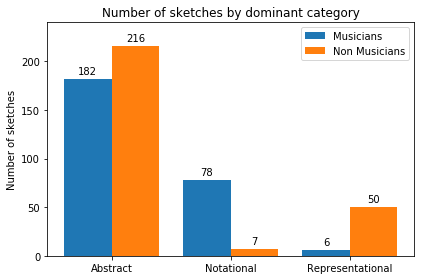

In [22]:
#Compare average values for musicians and non-musicians
musician_df = personal_df.query('`Music Pro` == True')
musician_indices = list(musician_df.index)

n_m_count = 0 #Notational Musician
r_m_count = 0 #Representational Musician
a_m_count = 0 #Abstract Musician

n_nm_count = 0 #Notational Non-Musician 
r_nm_count = 0 #Representational Non-Musician 
a_nm_count = 0 #Abstract Non-Musican

for i in range(0,2*nop):
    for j in range(0,nos):
        n = notational[i][j]
        r = representational[i][j]
        a = abstract[i][j]
        if math.floor(i/2) in musician_indices:
            if n >= 0.5 and r < 0.5 and a < 0.5:
                n_m_count += 1
            elif r >= 0.5 and n < 0.5 and a < 0.5:
                r_m_count += 1
            elif a >= 0.5 and n < 0.5 and r < 0.5:
                a_m_count += 1
        else:
            if n >= 0.5 and r < 0.5 and a < 0.5:
                n_nm_count += 1
            elif r >= 0.5 and n < 0.5 and a < 0.5:
                r_nm_count += 1
            elif a >= 0.5 and n < 0.5 and r < 0.5:
                a_nm_count += 1


#Grouped Bar Plot
labels = ['Abstract', 'Notational', 'Representational']
m = [a_m_count,n_m_count,r_m_count]
nm = [a_nm_count,n_nm_count,r_nm_count]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, m, width, label='Musicians')
rects2 = ax.bar(x + width/2, nm, width, label='Non Musicians')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Number of sketches by dominant category')
ax.set_ylabel('Number of sketches')
ax.set_ylim(0,240)
#ax.set_title('Mean cotegory scores by music proficiency')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

The above chart shows the number of sketches by dominant category divided between musicians and non musicians. We only take single categories here because (A,N and R) because they weren't many sketches in the mixed categories (NA,NR,AR,NRA).

Below we use the chi-squared test to determine if music proficiency has an influence on the sketch categories. First using the test for contingency tables and then testing if the frequencies for each category significantly vary from the expected values.

In [23]:
obs = np.array([m,nm])
chi2,p,dof,ex = stats.chi2_contingency(obs)

if p<0.05:
    print('The Nullhypothesis can be rejected')
    
a_s, a_p = stats.chisquare([a_m_count,a_nm_count],ex[:,0])
n_s, n_p = stats.chisquare([n_m_count,n_nm_count],ex[:,1])
r_s, r_p = stats.chisquare([r_m_count,r_nm_count],ex[:,2])

print('Abstract: Statistics: ' + str(a_s) + ' P-Value: ' + str(a_p))
print('Notational: Statistics: ' + str(n_s) + ' P-Value: ' + str(n_p))
print('Representational: Statistics: ' + str(r_s) + ' P-Value: ' + str(r_p))

The Nullhypothesis can be rejected
Abstract: Statistics: 2.0888857241673966 P-Value: 0.14837425620413838
Notational: Statistics: 61.17469238707629 P-Value: 5.222859669342474e-15
Representational: Statistics: 33.44365721997301 P-Value: 7.335862753274796e-09


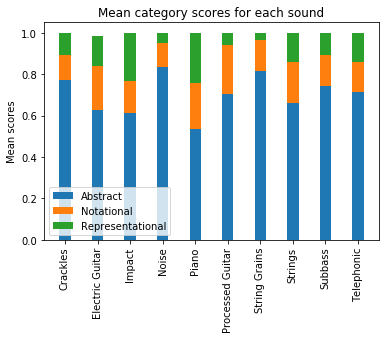

In [43]:
#Different drawing approaches for each sound
n_sounds = []
r_sounds = []
a_sounds = []
for _ in range(nos):
    n_sounds.append([])
    r_sounds.append([])
    a_sounds.append([])
    
for i in range(2*nop):
    for j in range(nos):
        n_sounds[j].append(notational[i][j])
        r_sounds[j].append(representational[i][j])
        a_sounds[j].append(abstract[i][j])

#Grouped Bar Plot

labels = sound_index
n_m = [np.mean(i) for i in n_sounds] 
r_m = [np.mean(i) for i in r_sounds]
a_m = [np.mean(i) for i in a_sounds]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, a_m, width, label='Abstract')
ax.bar(labels, n_m, width, bottom=a_m,
       label='Notational')
ax.bar(labels, r_m, width, bottom=[a_m[i]+n_m[i] for i in range(nos)], label='Representational')

ax.set_ylabel('Mean scores')
ax.legend()

_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Mean category scores for each sound')
plt.show()

The above graph shows the average values of each sketch category for all different sounds. 

Below we test if there is a significant differences in the choice for abstract elements between the sounds. 

In [25]:
#Friedman test to test differences between abstract representations for all sounds
x = a_sounds #all samples
stats.friedmanchisquare(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9])

FriedmanchisquareResult(statistic=84.51770506499315, pvalue=2.0364307140103885e-14)

In [26]:
#Pairwise comparison for differences in abstract representations between sounds with Wilcoxon 
p_values = np.zeros([nos,nos])
stat_values = np.zeros([nos,nos])
ntests = 45 #Number of Tests

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

for i in range(nos):
    for j in range(i+1,nos):
        stat, p = stats.wilcoxon(x[i],x[j])
        p_adjusted = p #* float(ntests) #p * Bonferroni correction
        p_values[i,j] = p_adjusted
        stat_values[i,j] = stat

d = pd.DataFrame(data=p_values.T, index=sound_index, columns=sound_index).style.applymap(color_negative_red)
d

/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Crackles,Telephonic,Strings,String Grains,Subbass,Noise,Piano,Impact,Processed Guitar,Electric Guitar
Crackles,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Telephonic,0.010515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Strings,0.001290,0.224273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
String Grains,0.653259,0.014109,0.000519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Subbass,0.270643,0.437614,0.002376,0.143854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Noise,0.010515,0.000345,0.000013,0.502335,0.004781,0.000000,0.000000,0.000000,0.000000,0.000000
Piano,0.000095,0.001098,0.005028,0.000001,0.000222,0.000002,0.000000,0.000000,0.000000,0.000000
Impact,0.011379,0.096177,0.387586,0.000784,0.065992,0.000028,0.133950,0.000000,0.000000,0.000000
Processed Guitar,0.210216,0.762137,0.282750,0.000925,0.410914,0.000842,0.000511,0.163474,0.000000,0.000000
Electric Guitar,0.001811,0.088935,0.380162,0.000287,0.005046,0.000016,0.059346,0.725349,0.126444,0.000000


## 2. Feature extraction

For the feature extraction we only take sketches into account that received a $\frac{1}{2}$ score or higher for abstract elements. Only in the abstract category would we expect basic features to correlate directly sound features

In [27]:
all_abstract_filter = []
for i in range(2*nop):
    flag = True
    for snd in range(nos):
        if abstract[i][snd] < 0.5:
            flag = False
    if flag:
        all_abstract_filter.append(i)

In [28]:
# "Master Array" that holds all info and will be converted into pandas dataframe
sketch_info = []

#Master Arrays for feature info and raw data
all_feature_info = []
all_raw_angles = []
all_raw_curves = []

all_features = [] #Save all the features for GMM and disimilarity matrix 

all_ft_np = np.zeros((nos,2*nop,12))

#Iterate through all sounds
points = []
for sound_number in range(nos):
    #Sketch info arrays for each sound
    number_of_paths = []
    path_length = []
    path_time = []
    total_speed = []
    intersections = []
    
    #Feature info arrays for each sound
    st = [] #Straight lines
    cun = [] #Narrow curves
    cuw = [] #Wide curves
    ob = [] #Obtruse angles 
    ri = [] #Right angles
    ac = [] #Acute angles
    raw_angles = []
    raw_curves = []
    
    #Temp array to store all feature vectors for this sound
    af_temp = []
    
    
    #iterate through all participants
    for participant_number in range(nop):
        #Get both iterations of every sound for each participant
        for version in range(2):
            #Only consider sketches from one category:
            if 2*participant_number + version in all_abstract_filter:
                #Get info for sketch and add it array
                snd = str(sound_number+1)
                if version == 1:
                    snd += 'B'
                #Get dataset for this sound and participant
                sketch_paths = get_sketch_paths(participant=participant_number+1,sound=snd,sketch_data = sketch_data)    
                
                temp = get_sketchinfo(paths=sketch_paths)
                number_of_paths.append(temp[0])
                path_length.extend(temp[1])
                path_time.extend(temp[2])
                points.extend(temp[3])
                s = sum(temp[1])/sum(temp[2]) #Calculate overall speed dividing total length by total drawing time
                total_speed.append(s)
                
                #Get overlaps
                _,i = get_intersections(sketch_paths,canvas=(750,750))
                
                #Intersections per 100px path length
                this_i = 100*i/sum(temp[1])
                intersections.append(this_i)

                #Get feature points
                ss = short_straw(sketch_paths)
                #Get info about feature points
                feature_info = ss[2]
                raw_angles.extend(ss[4])
                raw_curves.extend(ss[5])
                #Divide by number of paths
                #st.append(feature_info['straight'])
                
                #Divide by total path length
                this_cun = 100*feature_info['narrow curve']/sum(temp[1])
                this_cuw = 100*feature_info['wide curve']/sum(temp[1])
                this_ob = 100*feature_info['obtuse']/sum(temp[1])
                this_ri = 100*feature_info['right']/sum(temp[1])
                this_ac = 100*feature_info['acute']/sum(temp[1])
                cun.append(this_cun)
                cuw.append(this_cuw)
                ob.append(this_ob)
                ri.append(this_ri)
                ac.append(this_ac)
                
                #Save data to master array for GMM
                '''
                #0:NumberOfPaths 1:Mean Path Length 2:Mean Time 3:Total Speed 4:Intersections
                5:Narrow Curve 6:Wide Curve 7:Obtuse 8:Right 9:Acute
                '''
                af_temp.append([temp[0],np.mean(temp[1]),np.mean(temp[2]),s,this_i,this_cun,this_cuw,
                this_ob,this_ri,this_ac, np.mean(ss[4]),np.mean(ss[5])])
                
                for k,ft in enumerate([temp[0],np.mean(temp[1]),np.mean(temp[2]),s,this_i,this_cun,this_cuw, this_ob,this_ri,this_ac, np.mean(ss[4]),np.mean(ss[5])]):
                    all_ft_np[sound_number,participant_number*2 + version,k] = ft
                    
            else:
                for k in range(12):
                    all_ft_np[sound_number,participant_number*2 + version,k] = np.nan 
    #Get mean for each sketch info
    avg_number_of_paths = np.mean(number_of_paths)
    avg_path_length = np.mean(path_length)
    avg_path_time = np.mean(path_time)
    avg_speed = np.mean(total_speed)    
    avg_inter = np.mean(intersections)

    #Get means for each feature percentages
    #mean_st = np.mean(st)
    mean_cun = np.mean(cun)
    mean_cuw = np.mean(cuw)
    mean_ob = np.mean(ob)
    mean_ri = np.mean(ri)
    mean_ac = np.mean(ac)
    
    #Add feature info and raw data to arrays
    all_feature_info.append([mean_cun,mean_cuw,mean_ob,mean_ri,mean_ac,np.median(raw_angles),np.median(raw_curves)])
    all_raw_angles.append(raw_angles)
    all_raw_curves.append(raw_curves)
    #Add info to for this sound to "Master Array"
    sketch_info.append([avg_number_of_paths,avg_path_length,avg_path_time,1000*avg_speed,avg_inter])
    
    #Add to GMM array
    all_features.append(af_temp)


/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
aft_df = pd.DataFrame(data = [np.nanmean(all_ft_np[i,:,:10],axis=0) for i in range(nos)],index=sound_index,columns=['Number of strokes','Average stroke length [px]','Average stroke time[ms]','Average speed [px/ms]','Intersections [1/100px]','Narrow Curves [1/100px]','Wide Curves [1/100px]','Obtuse Angles [1/100px]','Right Angles [1/100px]','Acute Angles [1/100px]']) 
aft_df = aft_df.round(2)
aft_df        

,Number of strokes,Average stroke length [px],Average stroke time[ms],Average speed [px/ms],Intersections [1/100px],Narrow Curves [1/100px],Wide Curves [1/100px],Obtuse Angles [1/100px],Right Angles [1/100px],Acute Angles [1/100px]
Crackles,8.00,509.89,4514.63,0.17,2.41,0.68,0.61,1.19,0.32,1.00
Telephonic,3.95,1774.75,5704.89,0.36,0.73,0.18,0.43,0.50,0.08,0.37
Strings,3.73,868.54,4520.27,0.27,0.30,0.14,0.23,0.20,0.07,0.11
String Grains,12.23,727.32,2155.59,0.30,2.15,0.32,0.26,0.56,0.18,0.76
Subbass,3.45,1540.32,7290.67,0.25,1.05,0.19,0.44,0.62,0.10,0.39
Noise,13.91,2035.74,2841.36,0.88,2.99,0.28,0.27,0.54,0.11,0.61
Piano,2.68,609.42,3770.61,0.28,0.26,0.04,0.27,0.23,0.00,0.04
Impact,6.23,1461.52,3687.80,0.70,0.88,0.23,0.30,0.27,0.08,0.41
Processed Guitar,3.86,1521.74,5224.53,0.41,0.45,0.11,0.25,0.44,0.06,0.18
Electric Guitar,3.86,1531.50,6455.80,0.31,1.14,0.18,0.11,0.43,0.08,0.59


In [30]:
#Friedman test to test differences between the sounds
for feature in range(10):
    x = [] #all samples
    for i in range(nos):
        x.append(all_ft_np[i,:,feature][~np.isnan(all_ft_np[i,:,feature])])

    #x = a_sounds 
    print(feature)
    print(stats.friedmanchisquare(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]))

0
FriedmanchisquareResult(statistic=49.92824566737613, pvalue=1.1112256461940944e-07)
1
FriedmanchisquareResult(statistic=39.66942148760336, pvalue=8.721177277146154e-06)
2
FriedmanchisquareResult(statistic=40.56198347107443, pvalue=6.008693457476089e-06)
3
FriedmanchisquareResult(statistic=53.31570247933894, pvalue=2.546422296625305e-08)
4
FriedmanchisquareResult(statistic=50.20851063829788, pvalue=9.84223032622535e-08)
5
FriedmanchisquareResult(statistic=43.245153933865474, pvalue=1.943348186409698e-06)
6
FriedmanchisquareResult(statistic=21.726197345643453, pvalue=0.009788439668216294)
7
FriedmanchisquareResult(statistic=43.54040404040406, pvalue=1.7150386037761209e-06)
8
FriedmanchisquareResult(statistic=49.901861786052386, pvalue=1.1239887400568342e-07)
9
FriedmanchisquareResult(statistic=56.41133077604017, pvalue=6.5497534535457865e-09)


In [31]:
#Pairwise comparison for differences in sketch geatures between sounds with Wilcoxon 
feature = 4
x=[]
for i in range(nos):
    x.append(all_ft_np[i,:,feature][~np.isnan(all_ft_np[i,:,feature])])
    
p_values = np.zeros([nos,nos])
stat_values = np.zeros([nos,nos])
ntests = 45 #Number of Tests
for i in range(nos):
    for j in range(i+1,nos):
        stat, p = stats.wilcoxon(x[i],x[j])
        p_adjusted = p #* float(ntests) #p * Bonferroni correction
        p_values[i,j] = p_adjusted
        stat_values[i,j] = stat

d = pd.DataFrame(data=p_values.T, index=sound_index, columns=sound_index).style.applymap(color_negative_red)
d

,Crackles,Telephonic,Strings,String Grains,Subbass,Noise,Piano,Impact,Processed Guitar,Electric Guitar
Crackles,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Telephonic,0.053396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Strings,0.001236,0.040136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
String Grains,0.733187,0.108043,0.001021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Subbass,0.101106,0.638906,0.011129,0.024970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Noise,0.708884,0.022809,0.000293,0.230474,0.006710,0.000000,0.000000,0.000000,0.000000,0.000000
Piano,0.001236,0.040136,0.683239,0.001866,0.009996,0.000390,0.000000,0.000000,0.000000,0.000000
Impact,0.022089,0.883846,0.022089,0.123045,0.832866,0.066608,0.005723,0.000000,0.000000,0.000000
Processed Guitar,0.018585,0.217957,0.619154,0.000123,0.073138,0.001155,0.469113,0.057533,0.000000,0.000000
Electric Guitar,0.130545,0.958420,0.022769,0.085341,0.782580,0.018675,0.003185,0.526681,0.180841,0.000000


## 3. Example of feature extraction
Display a specfic sketch and display information about it

In [32]:
#Create test dataset for shape primitives (square, triangle, circle)
test_data = []
shapes = []

#Create square
square = [[[100,650,650,100,100],[100,100,650,650,100],[0,1,2,3,4]]]
#Create triangle
triangle = [[[100,650,375,100],[100,100,650,100],[0,1,2,3]]]
#Create circle
circle_x = []
circle_y = []
circle_birth = []
r = 275
ctr = [375,375]
for i in range (360):
    angle = math.pi * i/180
    circle_x.append(r*np.cos(angle)+ctr[0])
    circle_y.append(r*np.sin(angle)+ctr[1])
    circle_birth.append(i)
shapes.append(square)
shapes.append(triangle)
shapes.append([[circle_x,circle_y,circle_birth]])

test_data.append(shapes)

/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


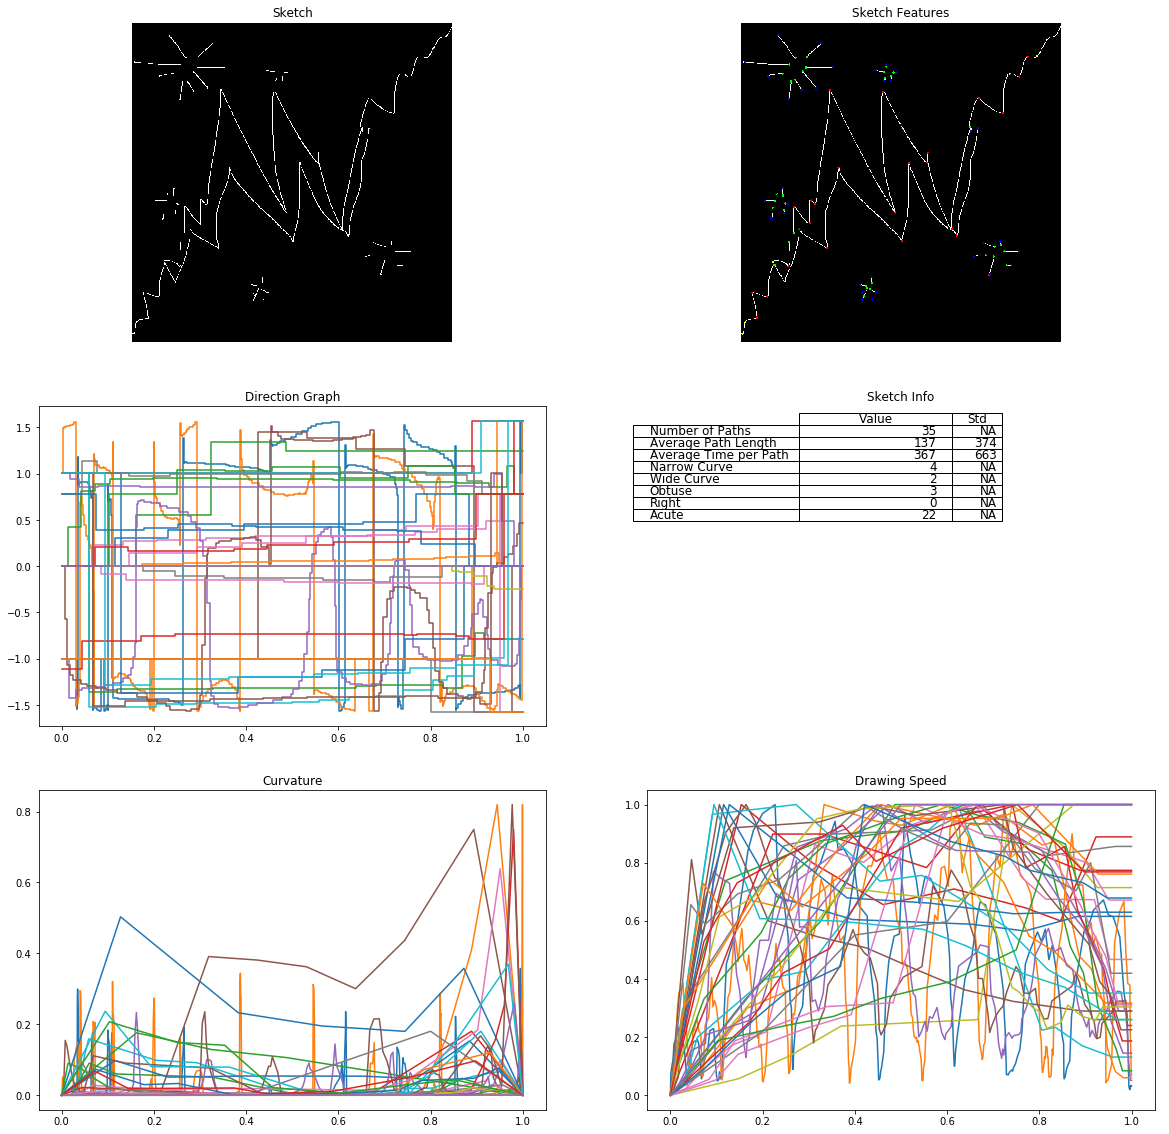

In [33]:
import scipy.stats as scipy
import sketchinfo

#Select sound and participant
sound_number =  '6'
participant_number = 5
dataset = sketch_data #Select which dataset to use: sketch_data for study data 
                      #test_data for test dataset with primitive shapes

#Get paths for specific sketch
sketch_paths = get_sketch_paths(participant=participant_number,sound=sound_number,sketch_data=dataset)

#Draw sketch data
sketch = draw_sketch(sketch_paths,(255,255,255,1)) #Call drawing function for specific sketch

#Get info for this sketch
number_of_paths, path_length, path_time, number_of_points = get_sketchinfo(sketch_paths)

#Get distances between points for this sketch and accumalted distances
distance_data, accl_dist_data = get_distances(sketch_paths)

#Get distances between points for this sketch and accumalted distances
time_data, accl_time_data = get_times(sketch_paths)

#Get direction graphs for this sketch
direction_data = direction_graph(sketch_paths,5)

#Get curvature
curvature_data = get_curvature(direction_data,accl_dist_data,2)

#Get speed data
speed_data = get_speed(distance_data,time_data,3)

#Get corners
ss = short_straw(sketch_paths)
all_corners = ss[0]
all_curves = ss[1]
feature_info = ss[2]
resampled_data = ss[3]

re_dst = get_distances(resampled_data)[0]

#Draw resampled version of sketch
resampled_sketch = draw_sketch(resampled_data,(255,255,255))
draw = ImageDraw.Draw(resampled_sketch)

#Draw start/end point and corners  
for i,path in enumerate(all_corners):
    for index in path:
        x = resampled_data[i][0][index]
        y = resampled_data[i][1][index]        
        if index == path[-1]: #End point is blue
            colour = (0,0,255)
        elif index == path[0]:
            colour = (0,255,0) #Start point is green
        else:
            colour = (255,0,0) #Rest is red
        draw.ellipse((x-2,y-2,x+2,y+2),fill=colour) #Corner points are red

#Draw curve points
for i,path in enumerate(all_curves):
    for index in path:
        x = resampled_data[i][0][index]
        y = resampled_data[i][1][index] 
        draw.ellipse((x-2,y-2,x+2,y+2),fill=(255,255,0)) #Curve points are yellow


#Great graphs and other display
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))

#Give titles to axes
axes[0,0].set_title('Sketch')
axes[0,0].axis('off')
axes[0,1].set_title('Sketch Features')
axes[0,1].axis('off')
axes[1,0].set_title('Direction Graph')
axes[1,1].set_title('Sketch Info')
axes[1,1].axis('off')
axes[2,0].set_title('Curvature')
axes[2,1].set_title('Drawing Speed')

#original on the left
axes[0,0].imshow(sketch)
#resampled with feature analysis on the right
axes[0,1].imshow(resampled_sketch)

#table with info second row on the right
cell_text = [[number_of_paths,'NA'],
            [int(np.mean(path_length)),int(np.std(path_length))],
            [int(np.mean(path_time)),int(np.std(path_time))],
            [feature_info['narrow curve'],'NA'],
            [feature_info['wide curve'],'NA'],
            [feature_info['obtuse'],'NA'],
            [feature_info['right'],'NA'],
            [feature_info['acute'],'NA']]

columns=('Value','Std')
rows=('Number of Paths','Average Path Length','Average Time per Path','Narrow Curve','Wide Curve','Obtuse','Right','Acute')
info_table = axes[1,1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='upper center', colWidths=(0.3,0.1,0.1))
info_table.auto_set_font_size(False)
info_table.set_fontsize(12)

#Draw graphs
for i in range(len(direction_data)):
    #Choose x-axis
    #x = accl_time_data[i] #absolute time
    x = [temp/accl_dist_data[i][-1] for temp in accl_dist_data[i]] #normalised distance
    #x = accl_dist_data[i] #absolute distance 
    
    #Direction Graph
    dir_y = direction_data[i]    
    #Plot data
    axes[1,0].step(x,dir_y) 
    
    #Curvature
    curve_y = [temp/(0.5*np.pi) for temp in curvature_data[i]] #normalise curvature data
    #Plot data
    axes[2,0].plot(x,curve_y)
    
    #Speed
    max_speed = max(speed_data[i])
    if(max_speed>0):
        speed_y = [temp/max(speed_data[i]) for temp in speed_data[i]] #normalise speed data
    else:
        speed_y = [0 for _ in speed_data[i]] #normalise speed data
    #Plot data
    axes[2,1].plot(x,speed_y)
    

#Show everything
plt.show()

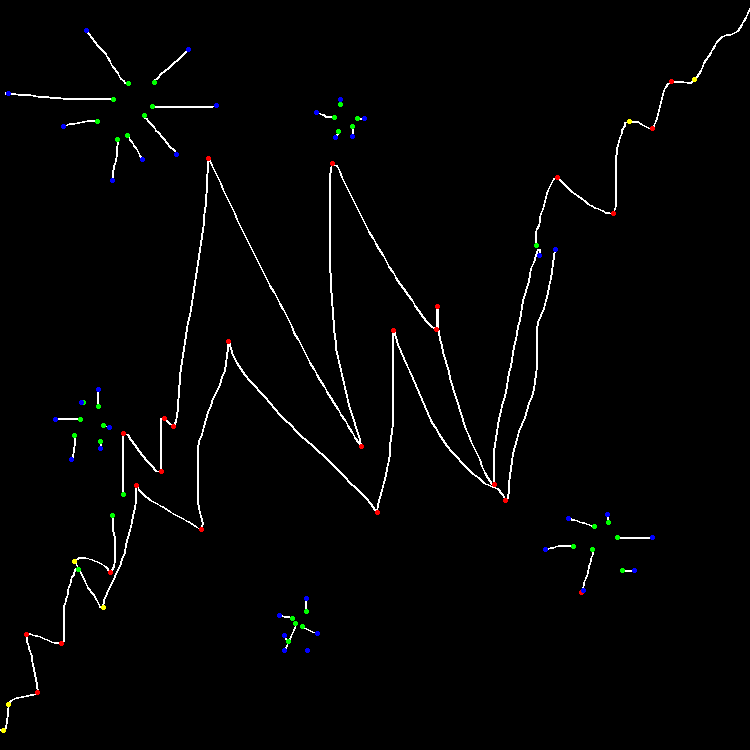

In [34]:
#Show sketch with feature points
'''
Green = starting point
Blue = end point
Red = corner point
Yellow = curve point
'''
resampled_sketch

# V. Feature Correlation

In [35]:
#Spearman correlations
rhos = np.zeros((audio_df.shape[1],(aft_df.shape[1])))
ps = np.zeros((audio_df.shape[1],(aft_df.shape[1])))

for i,audio_feature in enumerate(audio_df):
    a = audio_df[audio_feature]
    
    for j,sketch_feature in enumerate(aft_df):
        b = aft_df[sketch_feature]
        rho,p = stats.spearmanr(a,b)
        rhos[i][j] = rho
        ps[i][j] = p

In [36]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

cor_columns = list(aft_df.columns)
cor_df = pd.DataFrame(data=ps,index=audio_df.columns,columns=cor_columns)
sdf = cor_df.style.applymap(color_negative_red)

In [37]:
cor_columns = list(aft_df.columns)

cor2_df = pd.DataFrame(data=rhos,index=audio_df.columns,columns=cor_columns).drop('Reverb').round(2)

In [38]:
#Annotation with * for significance levels
cm_annot = []
for i,row in enumerate(ps):
    annot_row = []
    for j,p in enumerate(row):
        rho = rhos[i,j]
        pre = '.'
        if rho < 0:
            pre = '-.'
        rho = int(abs(rho) * 100)
        rho_formatted = pre + "{:02d}".format(rho)
        if p<0.001:
            rho_formatted += '***'
        elif p<0.01:
            rho_formatted += '**'
        elif p<0.05:
            rho_formatted += '*'        
        annot_row.append(rho_formatted)
    cm_annot.append(annot_row)

cm_annot_df = pd.DataFrame(data=cm_annot[:12])

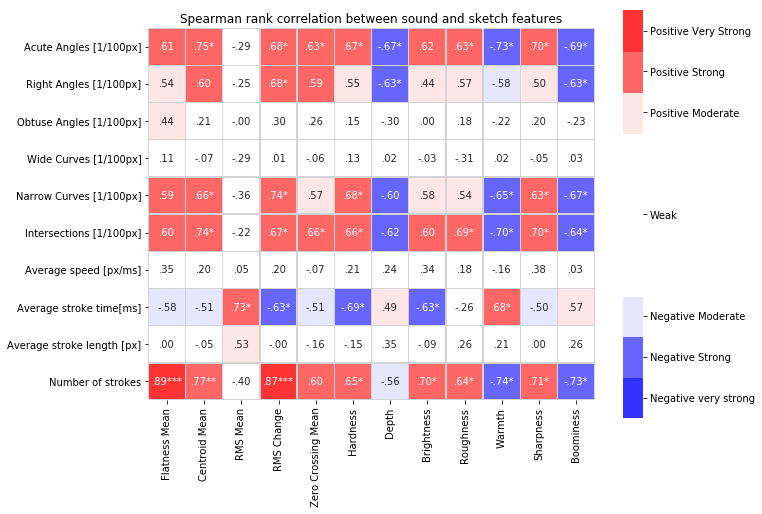

In [40]:
#Heatmap for correlation

#Colours for sections:
myColors = ((0.2,0.2,1.,1.),(0.4,0.4,1.,1.),(0.9,0.9,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,0.9,0.9,1.),(1.,0.4,0.4,1.),(1.,0.2,0.2,1.))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))


fig, ax = plt.subplots(figsize=(10,7.5))
hm = sns.heatmap(cor2_df.T, annot=cm_annot_df.T, vmin=-1,vmax=1, cmap=cmap, linewidths=.5, linecolor='lightgray',square=True, fmt='')
ax = hm
# Manually specify colorbar labelling after it's been generated
cb = ax.collections[0].colorbar
#cb = fig.colorbar(hm,ax=ax,orientation='vertical',drawedgdes=True)
cb.solids.set_edgecolor("face")
#colorbar.outline.set_color('black')
#colorbar.outline.set_linewidth(10)

cb.set_ticks([-0.9, -0.7, -0.5, 0.,0.5,0.7,0.9])
cb.set_ticklabels(['Negative very strong', 'Negative Strong', 'Negative Moderate','Weak','Positive Moderate','Positive Strong','Positive Very Strong'])


ax.set_ylim(0, 10)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title('Spearman rank correlation between sound and sketch features')
plt.show()